In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Clustering de semillas

In [38]:
SEED = 100495861

In [39]:
df = pd.read_csv('semillas.csv')
df.sample(5)

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
156,11.34,12.87,0.8596,5.053,2.849,3.347,5.003,3
97,18.98,16.57,0.8687,6.449,3.552,2.144,6.453,2
42,13.16,13.55,0.9009,5.138,3.201,2.461,4.783,1
114,20.97,17.25,0.8859,6.563,3.991,4.677,6.316,2
155,11.19,13.05,0.8253,5.250,2.675,5.813,5.219,3


In [40]:
df.describe()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


A partir de este estudio simple, se puede identificar que:
- Existen un máximo de tres clases
- El resto de los datos son floats, se necesita una mayor investigación.
- 
Para comprobar los PCAs, debemos de sacar X e Y

In [41]:
X = df.drop(columns=["clase"])
y = df["clase"]

print(X.shape, X.columns)
print(y.shape)

(210, 7) Index(['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria',
       'surco'],
      dtype='object')
(210,)


## Comprobar los scalers

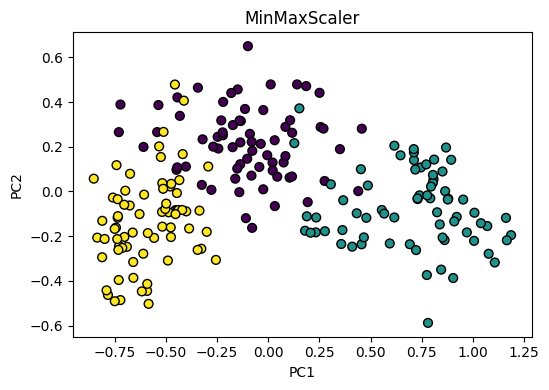

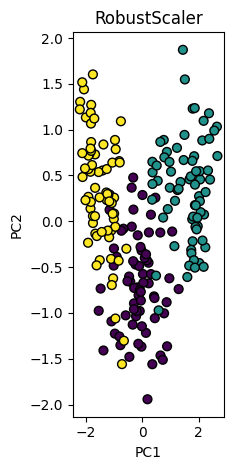

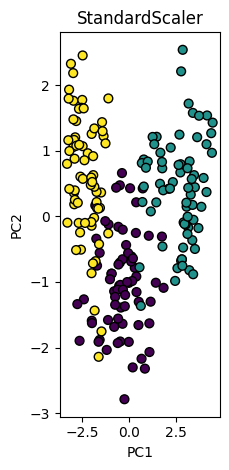

In [42]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
scaler_names = ["MinMaxScaler", "RobustScaler", "StandardScaler"]

plt.figure(figsize=(15, 4))

for i, (scaler, name) in enumerate(zip(scalers, scaler_names)):
    pipe = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_reduced = pipe.fit_transform(X)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
    plt.title(name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

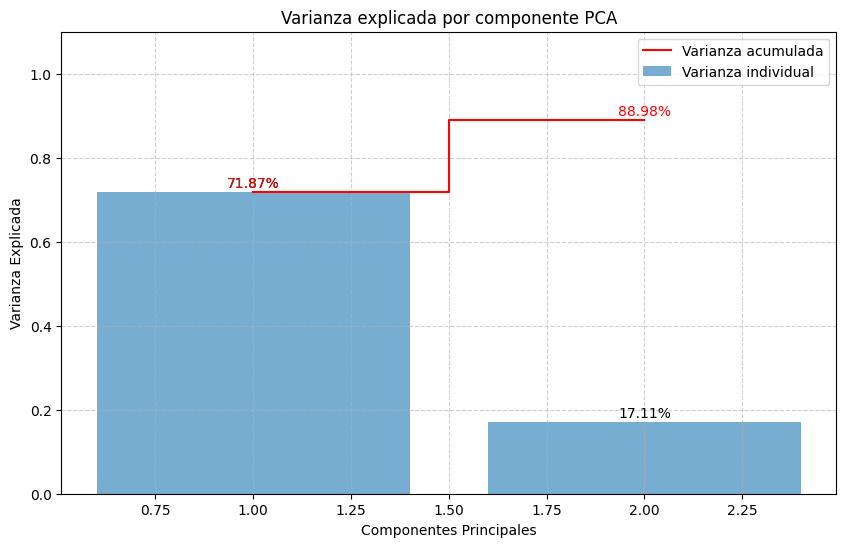

In [43]:
# Varianza explicada y acumulada
pca = pipe.named_steps["pca"]
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
    
# 1. Plot de Varianza Explicada y Acumulada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')
# Añadir valores exactos
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
    plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')
    
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza explicada por componente PCA')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Ojo avizor, parece que no hay mucha diferencia pero parece que con MinMaxScaler se encuentra todo mucho mejor agrupado que de normal. Tiraremos de ese hilo.

Además, somos capaces de explicar el **89% de la varianza** con solo dos componentes. Esto es muy importante de destacar, ya que podremos conseguir una serie de resultados muy buenos.

## Aplicación de técnicas

Se usarán:

- K-means
- Hierarchical
- DBScan

### K-means

Antes de todo, vamos a ejecutar una instancia de K-means sin ajuste de hiper-parámetros para ver el resultado.

[2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 0 0 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 2 1 2 2 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 0]


Text(0.5, 1.0, 'Clusters en el espacio PCA 2D')

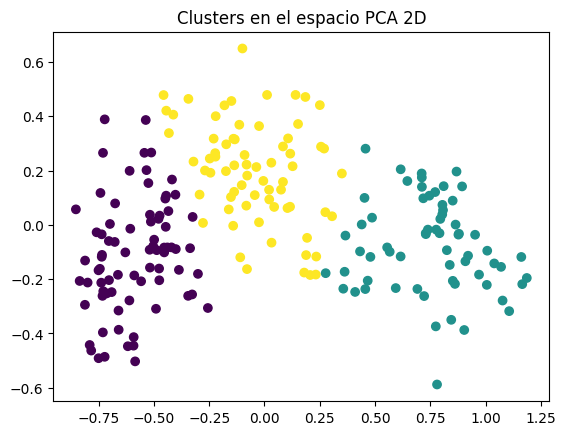

In [61]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

modelo_kmeans = KMeans(n_clusters=3, random_state=SEED)

# 3) PCA para visualizar
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2))
])

X_reduced = pipe.fit_transform(X)
modelo_kmeans.fit(X_reduced)
labels = modelo_kmeans.labels_

print(labels)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels)
plt.title("Clusters en el espacio PCA 2D")

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kmeans_2d(X_2d, modelo_kmeans):
    """
    Representa un único plot con los clusters KMeans y sus centroides.
    - X_2d: array (n_samples, 2) con tus dos componentes.
    - modelo_kmeans: modelo KMeans ya ajustado a X_2d.
    """

    # Predecir etiquetas de clusters
    y_pred = modelo_kmeans.predict(X_2d)
    
    # Crear figura y un solo eje
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot de cada cluster
    for label in np.unique(y_pred):
        ax.scatter(
            X_2d[y_pred == label, 0],
            X_2d[y_pred == label, 1],
            edgecolor='k',
            label=f"Cluster {label}"
        )

    # Añadir centroides
    ax.scatter(
        modelo_kmeans.cluster_centers_[:, 0],
        modelo_kmeans.cluster_centers_[:, 1],
        marker='*',
        s=200,
        c='black',
        label='Centroides'
    )

    # Ajustes de títulos y etiquetas
    ax.set_title('Clusters KMeans en 2D')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.legend()

    plt.tight_layout()
    plt.show()

    return y_pred

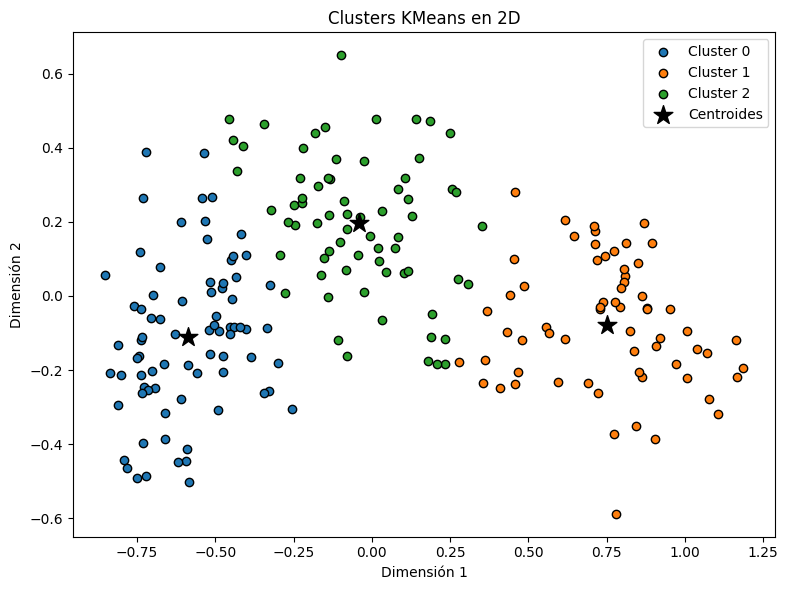

In [67]:
y_predict = plot_kmeans_2d(X_reduced, modelo_kmeans)

In [68]:
pd.crosstab(y, y_predict, dropna=False, rownames=['g_real'], colnames=['g_cluster'])

g_cluster,0,1,2
g_real,,,
1,10,2,58
2,0,62,8
3,67,0,3


Nos detecta 4 agrupaciones. No es lo que se espera, por lo que vamos a probar:

- CODO
- SILUETA

#### CODO

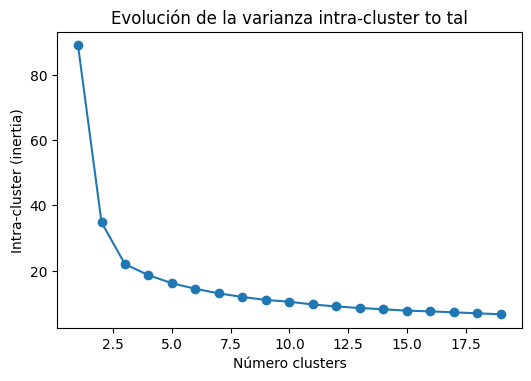

In [69]:
range_n_clusters = range(1, 20)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = SEED
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster to tal")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Se obtiene que `k_clusters` tiene un ideal entre 3-4. Pero como es difícil de comprender, se probará otro método.

#### SILUETA

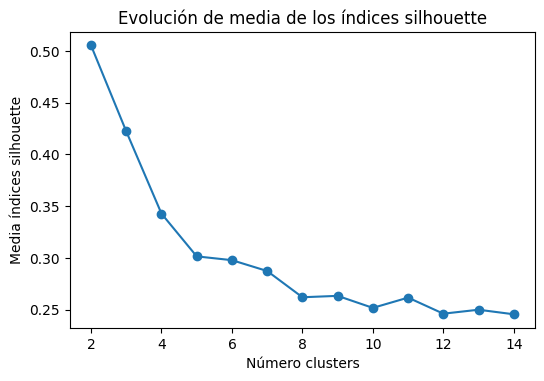

In [71]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Por lo tanto, podemos asegurar con casi total seguridad que la respuesta tiene mucho sentido que esté en **3 o 4**.

## Hierarchical

In [75]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

def plot_agglomerative_dendrogram(X, method='ward'):
    """
    Dibuja el dendrograma para un método de linkage dado.
    - X: array (n_samples, n_features).
    - method: uno de 'ward', 'complete', 'average' o 'single'.
    """
    Z = linkage(X, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title(f'Dendrograma ({method} linkage)')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()
    return Z


def evaluate_agglomerative_linkages(X, linkages=None, n_clusters_range=range(2, 11)):
    """
    Evalúa varios métodos de linkage calculando el silhouette score para distintos números de clusters.
    - X: array (n_samples, n_features).
    - linkages: lista de métodos de linkage (default ['ward', 'complete', 'average', 'single']).
    - n_clusters_range: rango de valores de n_clusters a probar.
    Retorna un dict con scores y grafica las curvas.
    """
    if linkages is None:
        linkages = ['ward', 'complete', 'average', 'single']
    results = {}
    plt.figure(figsize=(8, 6))

    for method in linkages:
        scores = []
        for k in n_clusters_range:
            model = AgglomerativeClustering(n_clusters=k, linkage=method)
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels) if k > 1 else np.nan
            scores.append(score)
        results[method] = scores
        plt.plot(list(n_clusters_range), scores, marker='o', label=method)

    plt.title('Silhouette Scores para métodos de linkage')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results


def plot_agglomerative_clusters(X_2d, modelo_agglo):
    """
    Representa los clusters de AgglomerativeClustering y sus centroides estimados.
    - X_2d: array (n_samples, 2).
    - modelo_agglo: modelo AgglomerativeClustering configurado.
    """
    labels = modelo_agglo.fit_predict(X_2d)
    centroids = np.array([X_2d[labels == l].mean(axis=0) for l in np.unique(labels)])

    fig, ax = plt.subplots(figsize=(8, 6))
    for label in np.unique(labels):
        ax.scatter(
            X_2d[labels == label, 0],
            X_2d[labels == label, 1],
            edgecolor='k',
            label=f"Cluster {label}"
        )
    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker='*',
        s=200,
        c='black',
        label='Centroides estimados'
    )

    ax.set_title('Clusters Agglomerative en 2D')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return labels


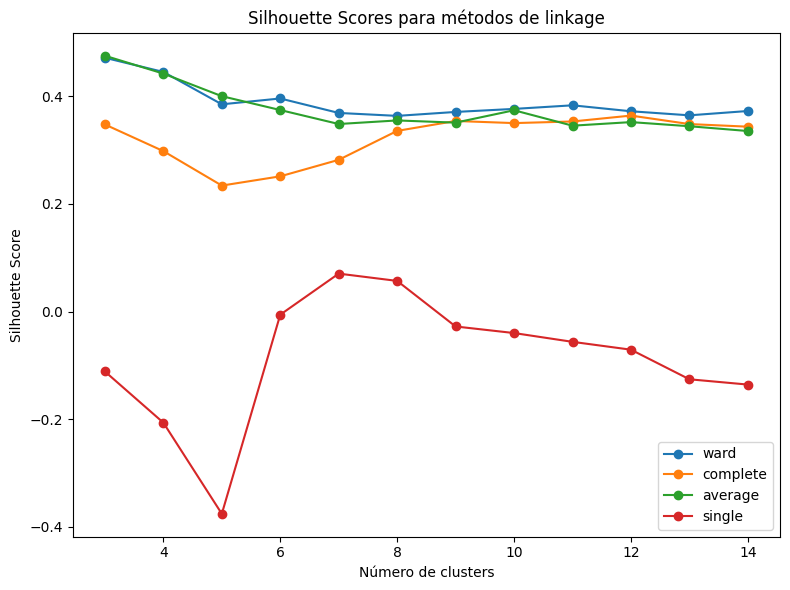

Best method: average --- n clusters: 3


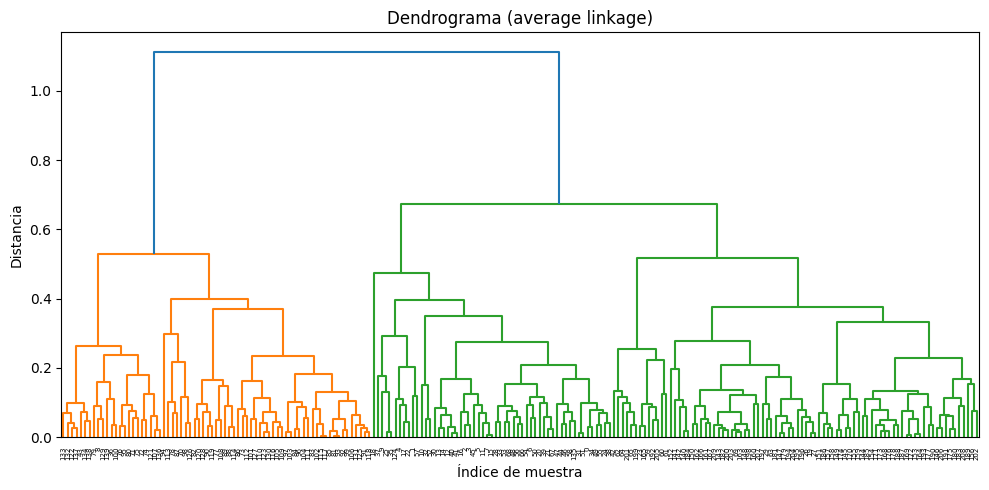

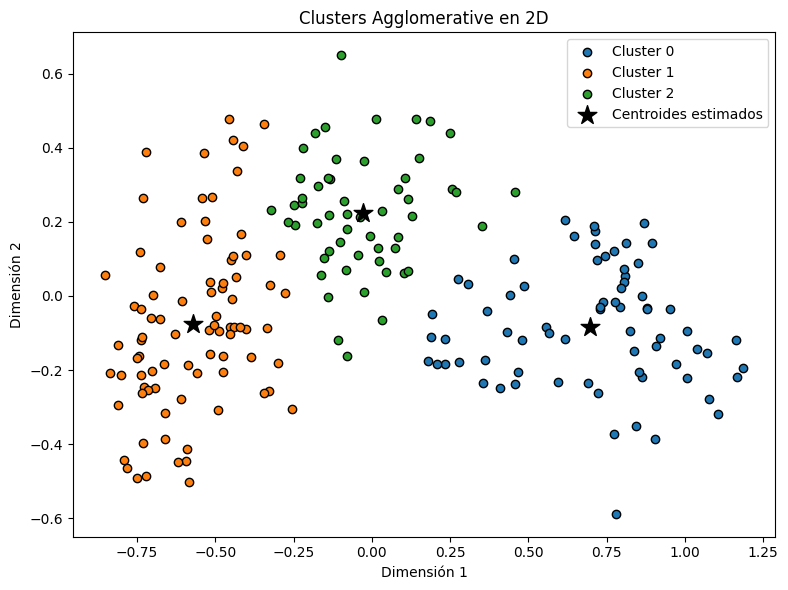

In [85]:
linkages = ['ward', 'complete', 'average', 'single'] # ward = prog lineal ole
n_clusters = range(3, 15)
results = evaluate_agglomerative_linkages(X_reduced, linkages=linkages, n_clusters_range=n_clusters) # no hierarchical, just links

best_method = max(results, key=lambda m: max(results[m]))
best_scores = results[best_method]
opt_k = n_clusters[np.nanargmax(best_scores)]
print(f"Best method: {best_method} --- n clusters: {opt_k}")

Z = plot_agglomerative_dendrogram(X_reduced, method=best_method)

model_opt = AgglomerativeClustering(n_clusters=opt_k, linkage=best_method)
labels_opt = plot_agglomerative_clusters(X_reduced, model_opt)

Como se puede apreciar, especialmente en el segundo gráfico (dendrograma), se propone un total de 2-3 clusters. Al estudiar el espacio de salto, claramente se aprecian dos clusters. El tercero es un poco más rebuscado, pero siguiendo este método podría decirse que la solución se encuentra en **2-3 clusters**.